<a href="https://colab.research.google.com/github/SamuelSuaV/Cocktail-RAG/blob/main/Cocktail_RAG_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación de un RAG de Recetas de Cocteles

## 0. Setup Inicial

In [24]:
# Instalacion de paquetes de Hugging Face
!pip install -U --quiet "transformers>=4.44.0" "accelerate>=0.33.0" "bitsandbytes>=0.43.1" "peft>=0.12.0" sentencepiece
!pip install -U --quiet --no-cache-dir bitsandbytes

import os, sys, time
print("Reiniciando el runtime para activar bitsandbytes…")
#time.sleep(1)
#os.kill(os.getpid(), 9)

Reiniciando el runtime para activar bitsandbytes…


In [25]:
# Stack para construir RAG
!pip -q install langchain langchain-community langchain-text-splitters faiss-cpu sentence-transformers ragas unidecode


In [26]:
# Otras importaciones
import pandas as pd
import re
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
import torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from textwrap import shorten
import matplotlib.pyplot as plt

# 1. Importación de base de datos


In [27]:
# Tomamos la base de Hugging Face
cocktails = pd.read_parquet("hf://datasets/brianarbuckle/cocktail_recipes/data/train-00000-of-00001-dcec52ec7fe8275d.parquet")
columns = ['title', 'ingredients', 'directions', 'misc', 'source', 'ner']

cocktails = cocktails[(~cocktails['ingredients'].isna()) & (~cocktails['directions'].isna())][columns].reset_index(drop=True)
cocktails

,title,ingredients,directions,misc,source,ner
0,151 Swizzle,[1.5 oz. 151-Proof Demerara Rum [Lemon Hart or...,[],[],Beachbum Berry Remixed,"[pernod, rum]"
1,20th Century,"[The 21st Century, 2 oz. Siete Leguas Blanco T...","[shake on ice and strain into coupe , The Best...",[],Jim Meehan,"[cocchi americano, pernod, tequila]"
2,20th Century,"[1.5 oz. Plymouth Gin, 3\/4 oz. Mari Brizard W...",[shake on ice and strain],[],PDT,"[lillet, gin]"
3,Abbey Cocktail,[],"[Shake liquid ingredients with ice., Strain in...",[Suggested glassware is Cocktail Glass],The Ultimate Bar Book,[]
4,Absinthe Drip,[1 1/2 ounces Pernod (or other absinthe substi...,[Pour Pernod into a pousse-caf or sour glass....,[The Absinthe Drip was made famous by Toulouse...,The Ultimate Bar Book,"[pernod, absinthe]"
...,...,...,...,...,...,...
870,Yellow Bird,"[ A Caribbean favorite., 1 ounce dark rum, 1 o...","[Shake liquid ingredients with ice., Strain in...",[Suggested glassware is Cocktail Glass],The Ultimate Bar Book,"[galliano, triple sec, rum, cointreau]"
871,Yellow Fever,"[1 1/2 ounces vodka, 1/2 ounce Galliano, 1/2 o...","[Shake ingredients with ice., Strain into a ch...",[Suggested glassware is Cocktail Glass],The Ultimate Bar Book,"[vodka, galliano]"
872,Yellow Parrot Cocktail,"[3/4 ounce yellow Chartreuse, 3/4 ounce Pernod...","[Shake ingredients with ice., Strain into a ch...",[Suggested glassware is Cocktail Glass],The Ultimate Bar Book,"[brandy, pernod, chartreuse]"
873,[The Spirit of the] Algonquin,"[ 2oz. 90 Proof Rye, .75oz. Lemon Juice, .75oz...",[shake on ice and strain],[Suggested glassware is Cocktail Glass],PDT,[]


# 2. Normalización de las columnas (listas/arrays → texto)

In [28]:
def list_to_str(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return ", ".join(str(i) for i in x if str(i).strip())

    if x is None:
        return ""
    try:
        if pd.isna(x):
            return ""
    except:
        pass
    return str(x)

In [29]:
cocktails["ingredients_str"] = cocktails["ingredients"].apply(list_to_str)
cocktails["directions_str"]  = cocktails["directions"].apply(list_to_str)
cocktails["misc_str"]        = cocktails["misc"].apply(list_to_str)
cocktails["ner_str"]         = cocktails["ner"].apply(list_to_str)

Verificamos la longitud de las recetas (la columna más larga) para determinar si debemos hacer chunking. Vemos que la longitud promedio es de 50.02 palabras y la máxima es de 367 palabras, lo cual muestra que nuestros documentos son en su mayoría cortos, aunque algunos superan el límite de tokens que tenemos presupuestado. Por lo tanto, eliminamos aquellos documentos que superan las 210 palabras.

La longitud promedio del texto combinado (número de palabras) es: 50.02
La longitud máxima del texto combinado (número de palabras) es: 367
Textos que superan las 210 palabras: 3


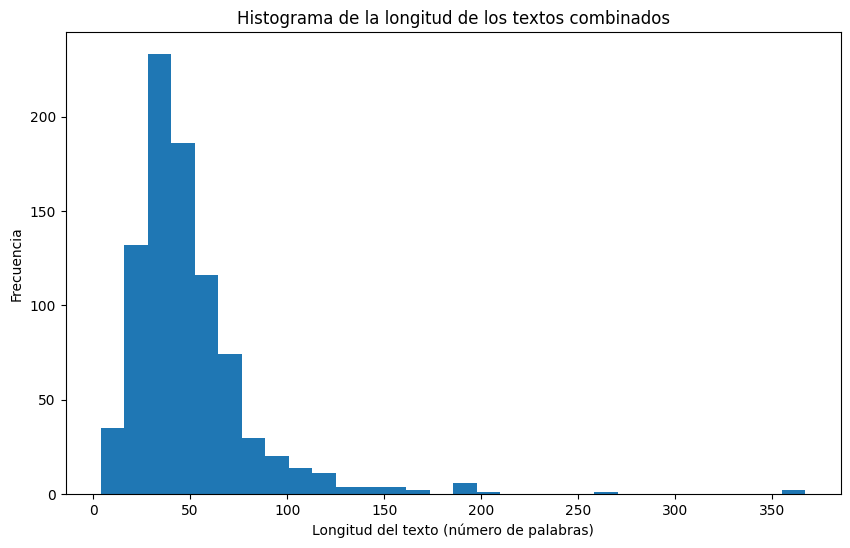

In [30]:
# Concatenamos todas las columnas
cocktails['combined_text'] = cocktails.apply(lambda row:
    f"{row['title']} {row['ingredients_str']} {row['directions_str']} {row['misc_str']} {row['ner_str']} {row['source']}", axis=1)

# Longitud promedio del texto combinado
average_combined_text_length_words = cocktails['combined_text'].apply(lambda x: len(x.split())).mean()
print(f"La longitud promedio del texto combinado (número de palabras) es: {average_combined_text_length_words:.2f}")

# Longitud máxima del texto combinado
max_combined_text_length_words = cocktails['combined_text'].apply(lambda x: len(x.split())).max()
print(f"La longitud máxima del texto combinado (número de palabras) es: {max_combined_text_length_words}")


# Calculamos la longitud en palabras de cada texto
cocktails['combined_text_length'] = cocktails['combined_text'].apply(lambda x: len(x.split()))

num_mayores_210 = (cocktails['combined_text_length'] > 210).sum()
print(f"Textos que superan las 210 palabras: {num_mayores_210}")

# Histograma
plt.figure(figsize=(10,6))
plt.hist(cocktails['combined_text_length'], bins=30)
plt.xlabel("Longitud del texto (número de palabras)")
plt.ylabel("Frecuencia")
plt.title("Histograma de la longitud de los textos combinados")
plt.show()



In [31]:
# Eliminamos los documentos con más de 210 palabras:
cocktails = cocktails[cocktails['combined_text_length'] <= 210].copy()

# 3. Construcción del texto unificado por cóctel

El encoder necesita un solo texto por documento. Aquí combinamos:
- título,
- ingredientes,
- instrucciones,
- notas (`misc`),
- ingredientes clave (`ner`),
- y la fuente;

en una sola columna llamada `text`, que será la entrada al modelo de embeddings.

In [34]:
# Filtrar para dejar solo con los textos de 210 palabras o menos
cocktails = cocktails[cocktails['combined_text_length'] <= 210].copy()

def row_to_text(row):
    return (
        f"Title: {row['title']}\n"
        f"Ingredients: {row['ingredients_str']}\n"
        f"Directions: {row['directions_str']}\n"
        f"Misc: {row['misc_str']}\n"
        f"Key ingredients: {row['ner_str']}\n"
        f"Source: {row['source']}"
    )

cocktails["text"] = cocktails.apply(row_to_text, axis=1)

cocktails[["title", "text"]].head()

,title,text
0,151 Swizzle,Title: 151 Swizzle\nIngredients: 1.5 oz. 151-P...
1,20th Century,Title: 20th Century\nIngredients: The 21st Cen...
2,20th Century,Title: 20th Century\nIngredients: 1.5 oz. Plym...
3,Abbey Cocktail,Title: Abbey Cocktail\nIngredients: \nDirectio...
4,Absinthe Drip,Title: Absinthe Drip\nIngredients: 1 1/2 ounce...


# 4. Encoder elegido: `sentence-transformers/all-MiniLM-L6-v2`

Usamos un **Sentence Transformer** open source (`all-MiniLM-L6-v2`) como encoder de texto a vector.

Características técnicas importantes:
- Está basado en **MiniLM**, un Transformer pequeño y eficiente (6 capas).
- Soporta **hasta 256 tokens** de entrada por texto.
- Produce un **embedding de 384 dimensiones** por cada texto completo.
- Usa *mean pooling*: promedia los embeddings de todos los tokens para obtener un solo vector por cóctel.
- Está publicado bajo licencia **Apache 2.0**, lo que permite su uso en proyectos académicos y aplicaciones prácticas.

Este encoder convierte cada receta de cóctel en un vector numérico que captura su significado.
Luego estos vectores se usan para búsqueda semántica con FAISS dentro del RAG.

In [35]:
#Encoder Elegido
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"

#Import del Encoder
encoder = HuggingFaceEmbeddings(
    model_name=embedding_model_name
)

# Textos y metadata
texts = cocktails["text"].tolist()
metadatas = cocktails[["title", "source"]].to_dict(orient="records")

# Vectorstore FAISS (parte R de RAG)
vectorstore = FAISS.from_texts(
    texts=texts,
    embedding=encoder,
    metadatas=metadatas
)

vectorstore

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [36]:
# Análisis Dimensional
lista = cocktails["text"].tolist()
cadena_mas_larga = mas_larga = max(lista, key=len)
print("La cadena más larga es:")
print(cadena_mas_larga)

print("\nEmbedding Cadena Más Larga:\n", encoder.embed_query(cadena_mas_larga))
print(f"\nDimensiones del Embedding: (1x{len(encoder.embed_query(cadena_mas_larga))})")
print(f"Tamaño Matriz de Embeddings: ({vectorstore.index.ntotal}x{len(encoder.embed_query(cadena_mas_larga))})")

La cadena más larga es:
Title: Pousse-Caf
Ingredients: LITERALLY MEANING “PUSH THE COFFEE,” these drinks were invented in France as after-dinner drinks in the early 1800s, and had worked their way to New Orleans by about the 1840s. One of the most labor- intensive, technique-driven drinks, a pousse-café’s multiple layers of liqueurs are sometimes more visually pleasing than the end flavor. The point is to be able to enjoy each liqueur separately as you sip through the layers., The method of layering liqueurs, usually with equal amounts of three to six liqueurs, involves slowly pouring one on top of another, from the heaviest on the bottom to the lightest on top, for visually dramatic strata of colorful liqueurs. After pouring the first (and heaviest) liqueur into a stemmed pousse-café or other straight-sided glass, slowly pour the next layer over the rounded back of a bar spoon, as close to the layer below as possible without the spoon touching the liquid in the glass. Pousse-cafés ca

# 6. Búsqueda semántica de cócteles (parte R de RAG)

En esta parte hacemos una consulta de ejemplo. El flujo es:

1. El usuario escribe un texto (`query`) describiendo lo que quiere.
2. El encoder convierte `query` en un embedding.
3. FAISS compara ese embedding con todos los cócteles y devuelve los `k` más similares.
4. Mostramos el título, la fuente y un fragmento del texto de cada resultado.

Luego, estos `docs` serían el **contexto** que se le pasa a un modelo generativo
para construir la respuesta final (parte G de RAG).


In [37]:
query = "sweet cocktail with rum and pineapple"
docs = vectorstore.similarity_search(query, k=3)
for i, d in enumerate(docs, start=1):
    print(f"\n=== Result {i} ===")
    print("Title:", d.metadata.get("title"))
    print("Source:", d.metadata.get("source"))
    print("Snippet:\n", d.page_content[:400], "...")

def encoder(query: str):
  docs = vectorstore.similarity_search(query, k=3)
  context_text = "\n\n---\n\n".join([doc.page_content for doc in docs])
  return context_text
print(encoder(query))


=== Result 1 ===
Title: Pineapple Express
Source: New York Times
Snippet:
 Title: Pineapple Express
Ingredients: 1.5 oz. Plantation "StigGin's Fancy" Pineapple Rum, 0.75 oz. 100 proof Rhum Agricole (preferably Neisson), 0.75 oz. Lime Juice, 0.5 oz. Simple Syrup
Directions: ---shake with ice, strain into coupe glass---, Garnish with squeeze grapeFruit twist over drink and discard
Misc: 
Key ingredients: rum
Source: New York Times ...

=== Result 2 ===
Title: Spiced Rum Coco Martini
Source: The Ultimate Bar Book
Snippet:
 Title: Spiced Rum Coco Martini
Ingredients: 2 ounces spiced rum (such as Captain Morgan), 1/2 ounce chocolate liqueur (such as Godiva), Orange twist, Maraschino cherry
Directions: Stir liquid ingredients in mixing glass with ice., Strain into a chilled cocktail glass., Run the orange peel around the rim, twist it over the drink, and drop it in, along with the cherry.
Misc: Suggested glassware is C ...

=== Result 3 ===
Title: Rum Bay Breeze
Source: The Ultimate Bar Boo

# 7. Implementación del decoder

In [38]:
model_name2 = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)
model2 = AutoModelForCausalLM.from_pretrained(
      model_name2,
      torch_dtype=torch.float16,
      device_map="auto"
  )

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [39]:
tokenizer2.pad_token = tokenizer2.eos_token
model2.config.pad_token_id = model2.config.eos_token_id

from transformers import GenerationConfig

def decoder(context, query):
    prompt = f"Contexto:\n{context}\n\nPregunta: {query}\n\nRespuesta:"

    inputs = tokenizer2(prompt, return_tensors="pt").to(model2.device)

    outputs = model2.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.7,
        top_p=0.95
    )

    full_output = tokenizer2.decode(outputs[0], skip_special_tokens=True)

    if "Respuesta:" in full_output:
        answer = full_output.split("Respuesta:")[1].strip()
    else:
        answer = full_output

    return answer

#8. Chat con el Modelo

In [40]:
try:
    while True:
        query = input("Haz una pregunta: ")
        if query.lower() in ["exit", "quit", "salir"]:
            print("Saliendo…")
            break

        context = encoder(query)
        print(decoder(context, query))

except KeyboardInterrupt:
    print("\nEjecución detenida por el usuario.")

Haz una pregunta: Dime un coctel con Mezcal con sabor ahumado


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Spanish Fly o Oaxaca Chakas no son cocteles con sabor ahumado específicamente. Sin embargo, puedes intentar agregar un toque de humo a la Spanish Fly agregando una rodaja de chipotle o una pequeña cantidad de tabasco ahumado en el instante coffee antes de servirlo. Otra opción sería intentar agregar una rodaja de chipotle o una pequeña cantidad de tabasco ahumado al mezcal antes de agregar los demás ingredientes de la Oaxaca Chakas.

Pero si quieres un coctel con sabor ahumado que use mezcal como base, te recomiendo el "Mezcal Old Fashioned" o el "Mezcal Smoke". Ambos cocteles utilizan mezcal en su base y agregar ingredientes como salsa de tabasco ahumada, bitters y sabor a caramelo para crear un sabor ahumado intenso.

---

Title: Mezcal Old Fashioned
Ingredients:

Ejecución detenida por el usuario.
